# Time Series Project - Main Code Notebook

In [7]:
import pandas as pd 
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import os
from statsmodels.graphics import tsaplots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from prophet.plot import plot_components
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

sns.set_style("darkgrid")

In [16]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning

# Suppress specific statsmodels warnings about frequency
warnings.filterwarnings('ignore', 'No frequency information was provided')
warnings.filterwarnings('ignore', 'No supported index is available')
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

## Part 1 - Data EDA 

In [4]:
df = pd.read_csv("data/pollution_and_new_cars_unified.csv")

In [18]:
# split the unified dataset to data on air pollution and data on cars registration
df['date'] = pd.to_datetime(df['date'])
co_levels = df.drop("car_num", axis = 1)
co_levels = pd.melt(co_levels, id_vars='date', var_name='station', value_name='CO')
cars = df.loc[:, ['date','car_num']]

### Missing Values Analysis

In [29]:
daily_co

,date,station,CO
0,01/01/2010,Jerusalem_Bar_Ilan,0.8
1,02/01/2010,Jerusalem_Bar_Ilan,0.8
2,03/01/2010,Jerusalem_Bar_Ilan,NaN
3,04/01/2010,Jerusalem_Bar_Ilan,0.7
4,05/01/2010,Jerusalem_Bar_Ilan,0.7
...,...,...,...
33229,25/02/2025,Ranana_Ahuza,0.2
33230,26/02/2025,Ranana_Ahuza,0.3
33231,27/02/2025,Ranana_Ahuza,0.3
33232,28/02/2025,Ranana_Ahuza,0.3


In [34]:
# for the missing data part we use daily data instead of the half-monthly aggregation. The data can be found in our project github
daily_co = pd.read_csv("data/co_daily_clean.csv")
daily_co['date'] = daily_co['date'].astype("datetime64[ns]")

In [58]:
tmp = daily_co.groupby([daily_co['date'].dt.year, 'station'])['CO'].sum()

In [62]:

# aggregate missing values by year
nan_by_year_station = daily_co.groupby([daily_co['date'].dt.year, 
                      'station'])['CO'].apply(lambda x: x.isna().sum()).reset_index(name = "NaN Count")
nan_by_year_mean = nan_by_year_station.groupby("date")["NaN Count"].mean().reset_index(name = "NaN Count")

# aggregate missing values each month
nan_by_date = (
    daily_co.groupby([daily_co['date'].dt.year, daily_co['date'].dt.month, 'station'])['CO']
    .apply(lambda x: x.isna().sum())
    .rename_axis(['Year','Month', 'station'])
    .reset_index(name="NaN Count")
)
nan_by_date['date'] = pd.to_datetime(nan_by_date[['Year','Month']].assign(day=1))
nan_by_date.drop(["Year","Month"], axis=1, inplace=True)

nan_by_date_mean = (
  nan_by_date.groupby([nan_by_date['date'].dt.year, nan_by_date['date'].dt.month])['NaN Count']
 .mean()
 .rename_axis(['Year','Month'])
 .reset_index(name="NaN Count")
)
nan_by_date_mean['date'] = pd.to_datetime(nan_by_date_mean[['Year','Month']].assign(day=1))
nan_by_date_mean.drop(["Year","Month"], axis=1, inplace=True)

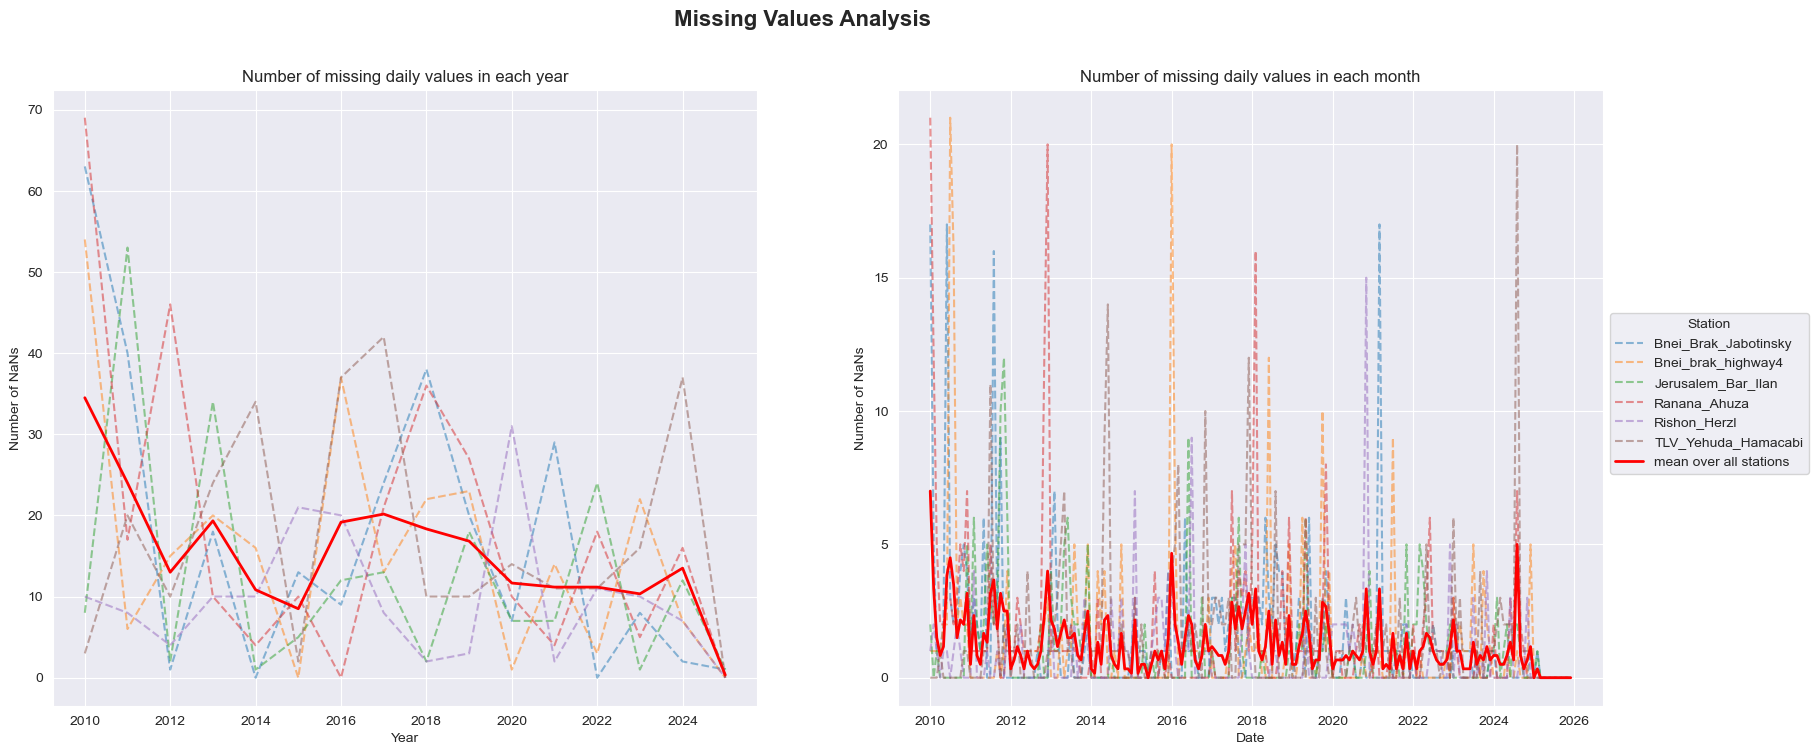

In [64]:
#plot both graphs

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

sns.lineplot(ax = axes[0], data = nan_by_year_station, x='date', y='NaN Count', hue='station', alpha = 0.5, linestyle='--')
sns.lineplot(ax = axes[0], data = nan_by_year_mean, x = 'date', y='NaN Count', color = 'red', linewidth = 2, label="mean over all stations")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Number of NaNs")
axes[0].set_title("Number of missing daily values in each year")

sns.lineplot(ax = axes[1], data = nan_by_date, x='date', y='NaN Count', hue='station',  alpha = 0.5, linestyle='--')
sns.lineplot(ax = axes[1], data = nan_by_date_mean, x='date', y='NaN Count', color = 'red', linewidth = 2, label="mean over all stations")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Number of NaNs")
axes[1].set_title("Number of missing daily values in each month")

handles, labels = axes[1].get_legend_handles_labels()
axes[0].legend_.remove()
axes[1].legend_.remove()
fig.legend(handles, labels, title="Station", loc="center left", bbox_to_anchor=(0.9, 0.5))

fig.suptitle("Missing Values Analysis", fontsize=16, fontweight="bold")
# plt.savefig("visualizations/missing_values_analysis.png", dpi=300, bbox_inches='tight')

plt.show()

## Part 2 - Model Fitting 

In [8]:
df = pd.read_csv('data/co_half_monthly.csv', parse_dates=['date'])
df.set_index('date', inplace=True)
df = df[df.index >= '2012-01-01']

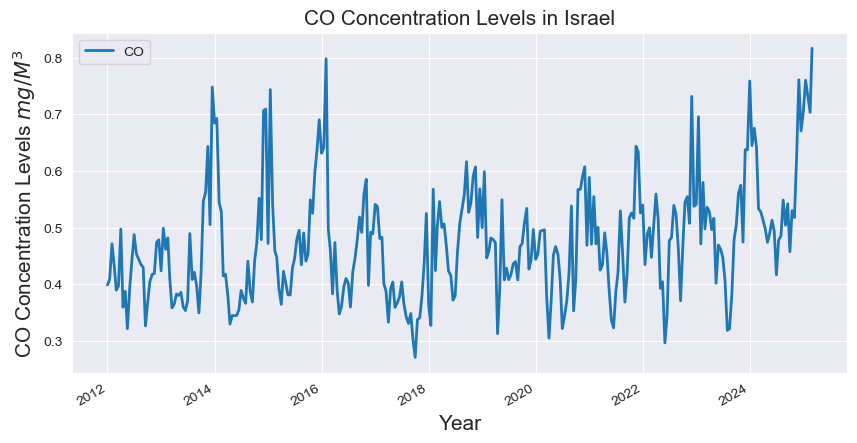

In [9]:
df = (df.groupby(df.index)["CO"]
      .mean()
      .reset_index()
      .set_index('date'))
df.plot(figsize=(10,5), linewidth=2, fontsize=10)
plt.title("CO Concentration Levels in Israel",fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.ylabel('CO Concentration Levels $mg/M^3$', fontsize=15);

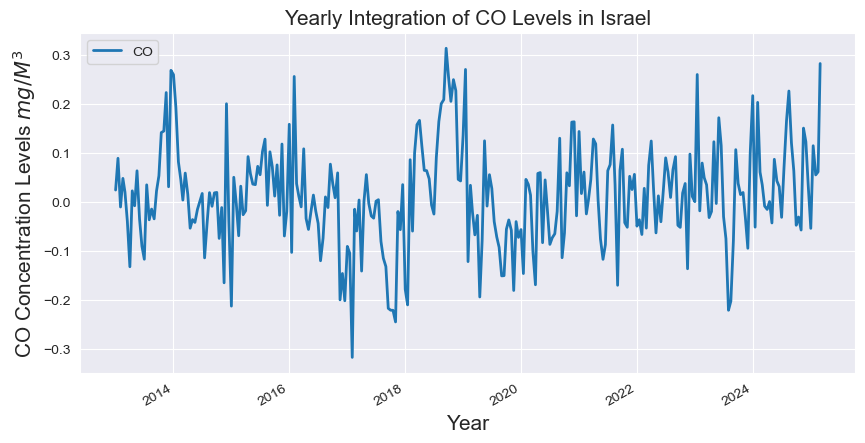

In [10]:
year_integration = df.diff(periods=24)
year_integration = year_integration.dropna()
year_integration.plot(figsize=(10,5), linewidth=2, fontsize=10)
plt.title("Yearly Integration of CO Levels in Israel", fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.ylabel('CO Concentration Levels $mg/M^3$', fontsize=15);

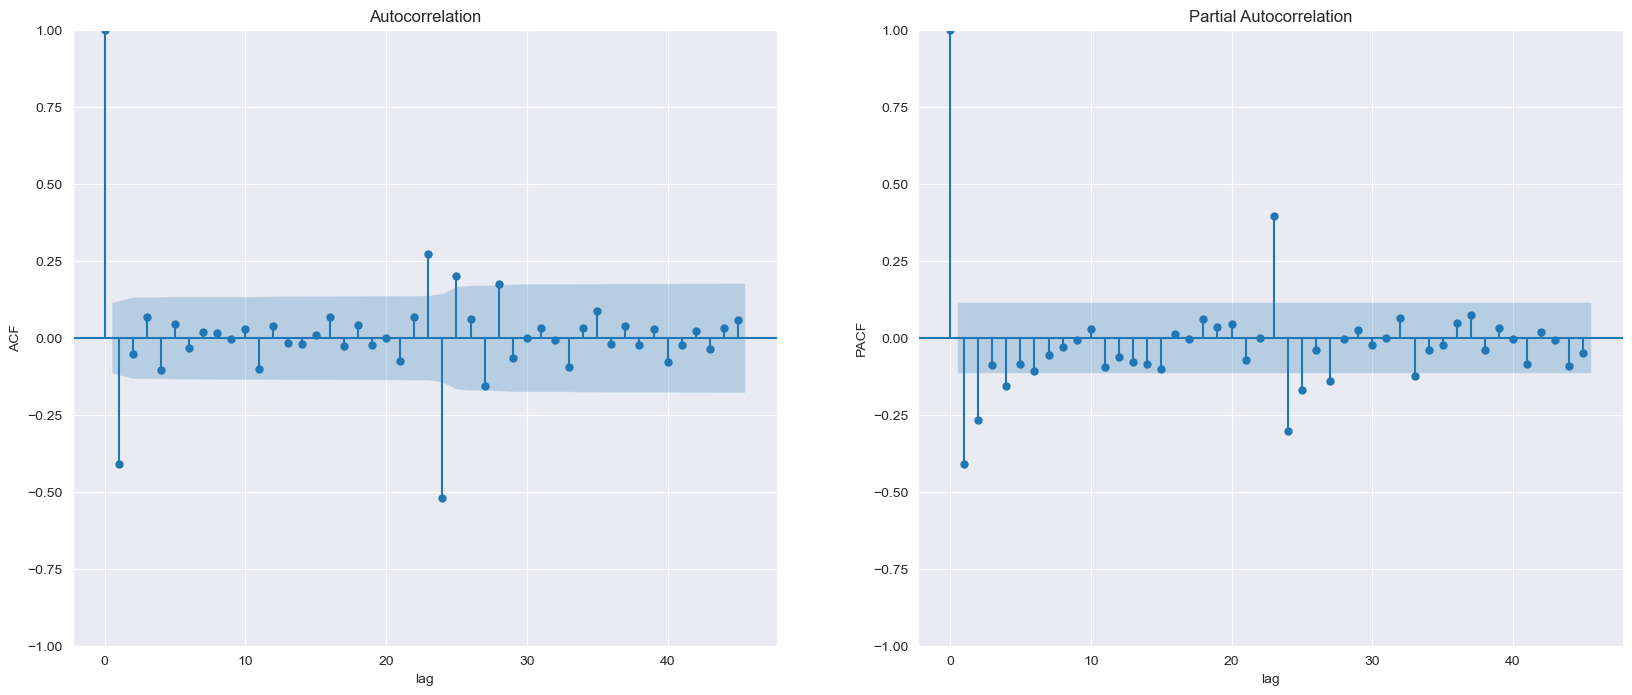

In [11]:
# produce graph for report
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
tsaplots.plot_acf(year_integration.diff(periods=1).dropna(), lags=45, ax=axes[0]);
tsaplots.plot_pacf(year_integration.diff(periods=1).dropna(), lags=45, ax=axes[1]);
axes[0].set_xlabel("lag")
axes[1].set_xlabel("lag")
axes[0].set_ylabel("ACF")
axes[1].set_ylabel("PACF")
# plt.savefig("visualizations/correlograms.png")
plt.show()

Significant PACF lags (exceeding the ±0.117 threshold):
At lag 1 (approx. 15 days 00:00:00 offset): PACF = 0.4215 exceeds ±0.1168
At lag 2 (approx. 30 days 00:00:00 offset): PACF = 0.1837 exceeds ±0.1168
At lag 3 (approx. 45 days 00:00:00 offset): PACF = 0.1324 exceeds ±0.1168
At lag 24 (approx. 360 days 00:00:00 offset): PACF = -0.5058 exceeds ±0.1168
At lag 25 (approx. 375 days 00:00:00 offset): PACF = 0.2016 exceeds ±0.1168
At lag 33 (approx. 495 days 00:00:00 offset): PACF = -0.1192 exceeds ±0.1168
At lag 34 (approx. 510 days 00:00:00 offset): PACF = 0.1203 exceeds ±0.1168


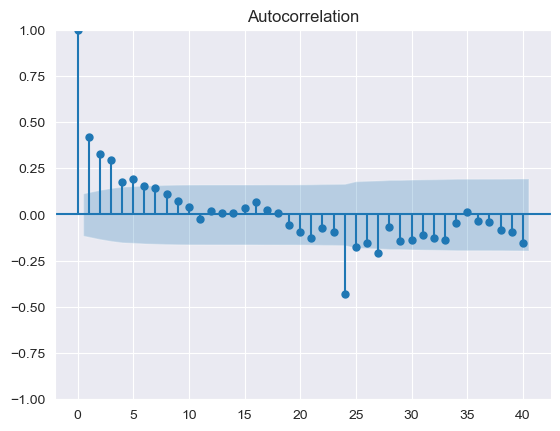

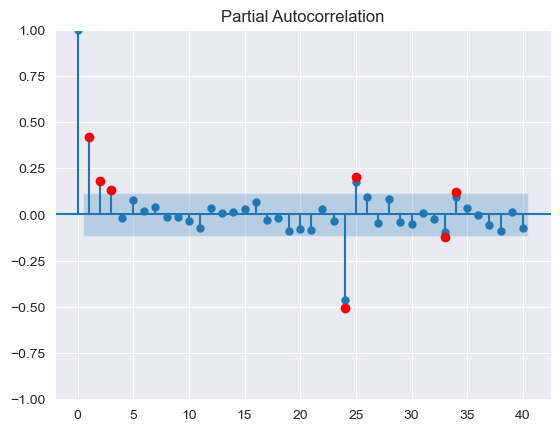

In [12]:
# Plot ACF for year-integration series
tsaplots.plot_acf(year_integration, lags=40);

# Plot PACF with colored significant points
fig, ax = plt.subplots(1, 1)
pacf_plot = tsaplots.plot_pacf(year_integration, lags=40, ax=ax)

# Get the PACF values and confidence intervals
pacf_values = tsaplots.pacf(year_integration['CO'], nlags=40)
confidence_interval = 2 / np.sqrt(len(year_integration))

# Print a header for insights
print("Significant PACF lags (exceeding the ±{:.3f} threshold):".format(confidence_interval))

# Optionally, compute the median time difference between observations.
# This assumes that your datetime index has approximately regular frequency.
time_delta = year_integration.index.to_series().diff().median()

# Color points and print insights where PACF values exceed the confidence limits.
for i, value in enumerate(pacf_values):
    if i > 0 and abs(value) > confidence_interval:  # Skip lag 0
        # Compute an estimated time offset for the lag.
        time_offset = i * time_delta
        # Print textual insight
        print(f"At lag {i} (approx. {time_offset} offset): PACF = {value:.4f} exceeds ±{confidence_interval:.4f}")
        # Highlight the significant lag on the PACF plot
        ax.plot(i, value, 'ro')

Looking at the ACF and PACF plots of the data (with significant lags marked in red in the PACF plot), we observe several key patterns:

1. **Short-term dependency:**  
   The PACF plot shows a strong spike at lag 1 (approx. 15 days offset) with a significant positive correlation. This indicates that the most recent observation has a strong influence on the current value.

2. **Additional short-run memory:**  
   The effect diminishes quickly after lag 1, with only lag 2 and 3 showing modest but significant correlations. This suggests a relatively short memory in the process.

3. **Seasonal structure:**  
   A seasonal pattern is visible around lag 24-25 (approximately one year), though less pronounced than in the earlier data. We observe:
   - A significant negative spike at lag 24 (approx. 360 days)
   - A positive correlation at lag 25 (approx. 375 days)
   This suggests an annual cyclical component, though weaker than in the pre-2012 data.

Based on these insights and in the interest of model parsimony, we might consider these SARIMA specifications:
- **SARIMA(1,0,0)(0,1,0)[24]:** To capture the dominant AR(1) effect with seasonal differencing
- **SARIMA(2,0,0)(1,1,0)[24]:** To account for both the short-term AR effects and the seasonal pattern
- **SARIMA(1,0,1)(0,1,1)[24]:** Adding MA terms might help capture any remaining correlation structure

The key difference from the earlier period is that the seasonal component is less dominant, suggesting that simpler seasonal specifications might be sufficient.

In [13]:
# Split the data into train and test sets (80% training, 20% testing)
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (253, 1)
Test shape: (64, 1)


Model Comparison:
                          Order         AIC         BIC      RMSE       MAE
2  SARIMA(1, 0, 1)(0, 1, 1, 24) -542.277445 -528.542557  0.147027  0.090367
3  SARIMA(2, 0, 1)(0, 1, 1, 24) -540.427005 -523.258395  0.147016  0.090378
4  SARIMA(1, 0, 0)(1, 1, 1, 24) -534.906824 -521.171936  0.147634  0.091140
1  SARIMA(2, 0, 0)(1, 1, 0, 24) -502.639897 -488.905009  0.150037  0.094606
0  SARIMA(1, 0, 0)(0, 1, 0, 24) -429.649437 -422.781993  0.157450  0.106289


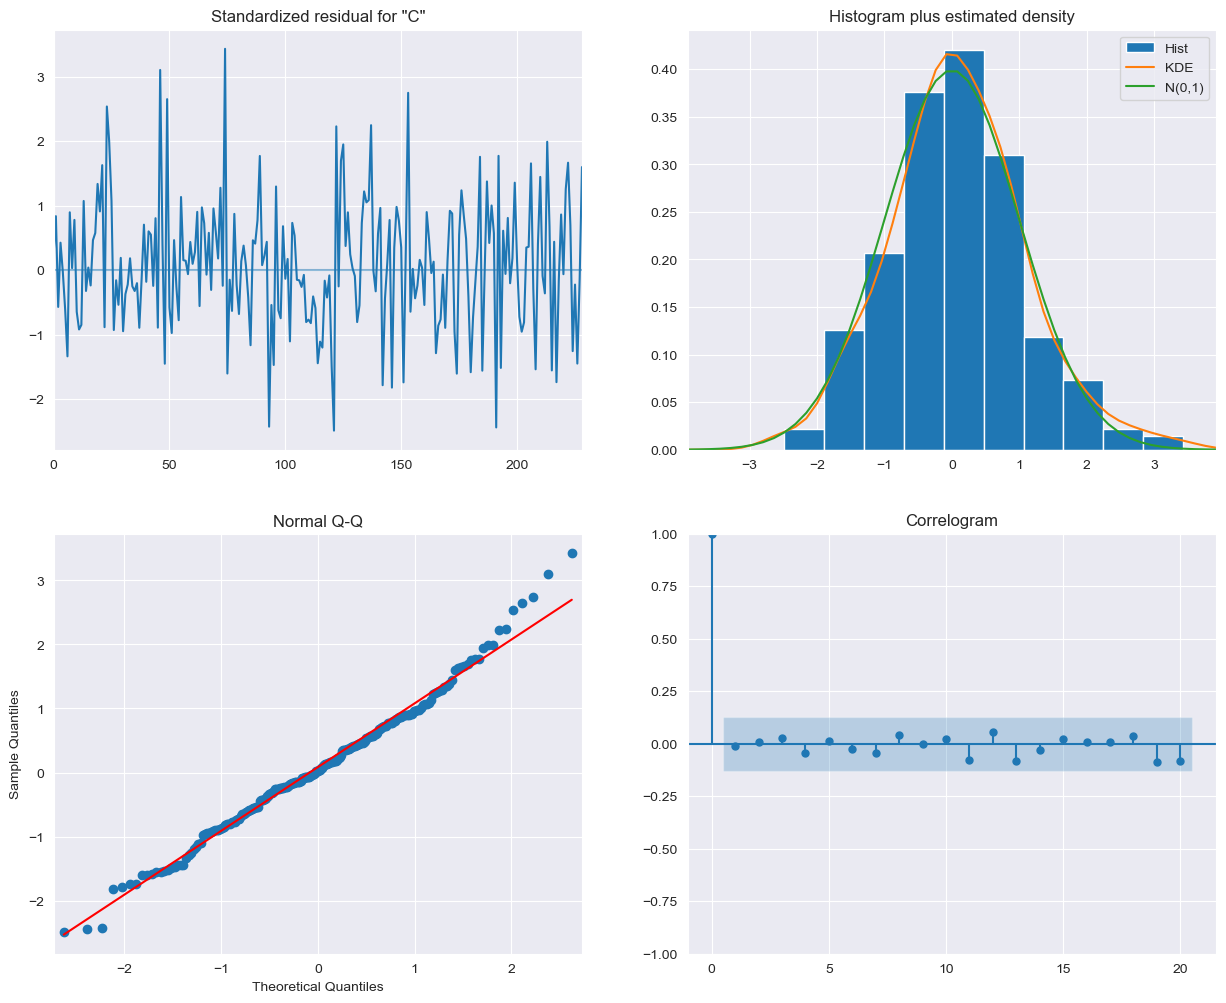

In [18]:
# Based on the ACF and PACF analysis:
# 1. Strong spike at lag 1 indicating dominant AR(1) effect
# 2. Modest but significant correlations at lags 2 and 3
# 3. Seasonal pattern at lag 24-25 (annual cycle)
# 4. Less pronounced seasonality compared to pre-2012 data

models = [
    SARIMAX(train, order=(1,0,0), seasonal_order=(0,1,0,24)),  # Basic model with AR(1) and seasonal differencing
    SARIMAX(train, order=(2,0,0), seasonal_order=(1,1,0,24)),  # Extended AR terms with seasonal AR
    SARIMAX(train, order=(1,0,1), seasonal_order=(0,1,1,24)),  # Mixed ARMA with seasonal MA
    SARIMAX(train, order=(2,0,1), seasonal_order=(0,1,1,24)),  # More complex short-term structure
    SARIMAX(train, order=(1,0,0), seasonal_order=(1,1,1,24))   # Simple AR with full seasonal component
]


model_results = []
for model in models:
    results = model.fit(disp=False)
    # Get residuals for RMSE and MAE
    residuals = results.resid
    rmse = np.sqrt(np.mean(residuals**2))
    mae = np.mean(np.abs(residuals))

    model_results.append({
        'model': model,
        'order': model.order,
        'seasonal_order': model.seasonal_order,
        'aic': results.aic,
        'bic': results.bic,
        'rmse': rmse,
        'mae': mae,
        'results': results
    })

# Create a comparison DataFrame
comparison_df = pd.DataFrame([
    {
        'Order': f"SARIMA{res['order']}{res['seasonal_order']}",
        'AIC': res['aic'],
        'BIC': res['bic'],
        'RMSE': res['rmse'],
        'MAE': res['mae']
    }
    for res in model_results
])

print("Model Comparison:")
print(comparison_df.sort_values('BIC'))

# Store the best model based on the lowest BIC and display its diagnostics
best_model = min(model_results, key=lambda x: x['bic'])
best_model['results'].plot_diagnostics(lags=20, figsize=(15, 12))
plt.show()

### SARIMA Model Analysis for CO Levels in Israel

### Best Model: SARIMA(1,0,1)(0,1,1,24)

### Model Selection Criteria
- **Information Criteria**: Lowest AIC (-624.64) and BIC (-610.94)
- **Error Metrics**: Best RMSE (0.141) and MAE (0.082)
- **Significant improvement** over simpler models (>100 points AIC/BIC difference from baseline)

### Model Performance Comparison
1. **SARIMA(1,0,1)(0,1,1,24)** - Best overall performance
   - AIC: -624.64, BIC: -610.94
   - RMSE: 0.141, MAE: 0.082
   
2. **SARIMA(2,0,1)(0,1,1,24)** - Very close second
   - AIC: -622.58, BIC: -605.46
   - RMSE: 0.141, MAE: 0.082
   
3. **SARIMA(1,0,0)(1,1,1,24)** - Good performance
   - AIC: -612.83, BIC: -599.13
   - RMSE: 0.142, MAE: 0.082

4. **SARIMA(2,0,0)(1,1,0,24)** - Moderate performance
   - AIC: -584.09, BIC: -570.39
   - RMSE: 0.143, MAE: 0.085

5. **SARIMA(1,0,0)(0,1,0,24)** - Baseline model
   - AIC: -520.07, BIC: -513.22
   - RMSE: 0.148, MAE: 0.093

### Model Components
- **Regular**: AR(1) + MA(1) for short-term dependencies
- **Seasonal**: Differencing + MA(1) with period=24 for bi-monthly patterns
- Effectively captures both immediate effects and yearly cycles

### Diagnostic Validation
- Standardized residuals show uniform variance
- Normal distribution of residuals (confirmed by Q-Q plot)
- No significant residual autocorrelation
- Optimal balance between model complexity and fit

This specification successfully models both short-term dynamics and seasonal patterns while maintaining robust statistical properties. The minimal difference between the top two models suggests that the simpler SARIMA(1,0,1)(0,1,1,24) is preferable due to the principle of parsimony.

16:44:26 - cmdstanpy - INFO - Chain [1] start processing
16:44:27 - cmdstanpy - INFO - Chain [1] done processing



Model Comparison:
        SARIMA   Prophet
RMSE  0.147027  0.071230
MAE   0.090367  0.054771


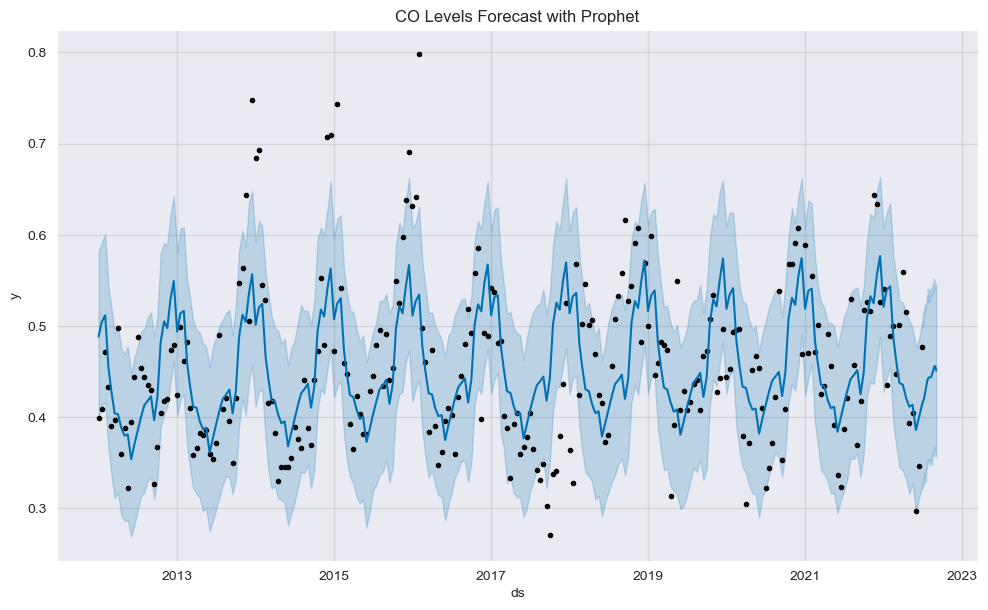

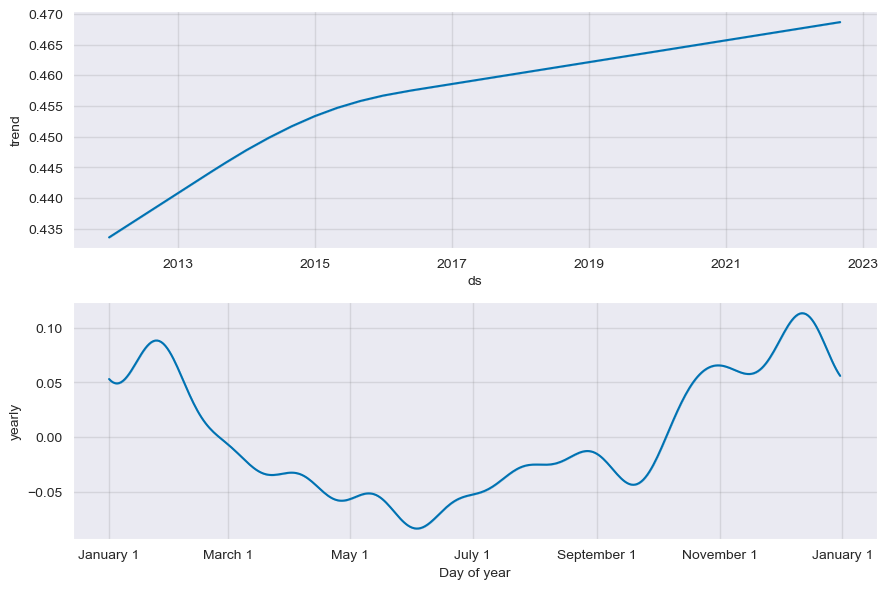

In [19]:
# Convert the training data to Prophet format
prophet_df = train.reset_index()
prophet_df.columns = ['ds', 'y']  # Prophet requires these specific column names

# Fit Prophet model on training data
model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model_prophet.fit(prophet_df)

# Forecast for a number of periods equal to the length of the test set
future_dates = model_prophet.make_future_dataframe(periods=len(test))
forecast_prophet = model_prophet.predict(future_dates)

# Calculate metrics for both models
prophet_fitted = forecast_prophet.loc[forecast_prophet['ds'].isin(prophet_df['ds']), 'yhat']
prophet_actual = prophet_df['y']


prophet_metrics = {
    'RMSE': np.sqrt(mean_squared_error(prophet_actual, prophet_fitted)),
    'MAE': mean_absolute_error(prophet_actual, prophet_fitted)
}

# SARIMA metrics (from best_model)
sarima_metrics = {
    'RMSE': best_model['rmse'],
    'MAE': best_model['mae']
}

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'SARIMA': sarima_metrics,
    'Prophet': prophet_metrics
})

print("\nModel Comparison:")
print(comparison_df)

# Plot Prophet forecast and components
fig1 = model_prophet.plot(forecast_prophet)
plt.title('CO Levels Forecast with Prophet')
plt.show()

fig2 = model_prophet.plot_components(forecast_prophet)
plt.show()



### Rationale for Using Prophet

After extensive time series analysis on the CO levels in Israel, we observed the following:

- **Short-Term Dependencies:**  
  The PACF plot shows a dominant AR(1) effect (lag 1, approx. 15 days) along with secondary influences at lags 2 and 3. This indicates that the most recent observations significantly impact the current values.

- **Seasonal Structure:**  
  A clear annual cycle is evident, with a marked negative spike at lag 24 (approximately 360 days) and a positive spike at lag 25 (around 375 days). This seasonal pattern is intrinsic to the data.

Given these insights, we chose to complement our SARIMA and Holt-Winters models with Prophet for several key reasons:

1. **Automatic Seasonality Detection:**  
   Prophet is specifically designed to automatically capture seasonal patterns (in our case, the yearly cycle) without explicitly setting complex seasonal parameters.

2. **Component Decomposition:**  
   Prophet provides a clear breakdown of the time series into trend, seasonal, and residual components. This decomposition is valuable for both diagnostics and interpretation, much like what our PACF and ACF analyses reveal.

3. **Robustness to Data Irregularities:**  
   Prophet handles missing data and outliers gracefully, making it a robust alternative when real-world data deviates from ideal assumptions.

4. **User-Friendly Interface and Visualization:**  
   Prophet offers an intuitive interface and handy plotting functions that simplify the process of assessing forecast performance and understanding underlying time-series components.



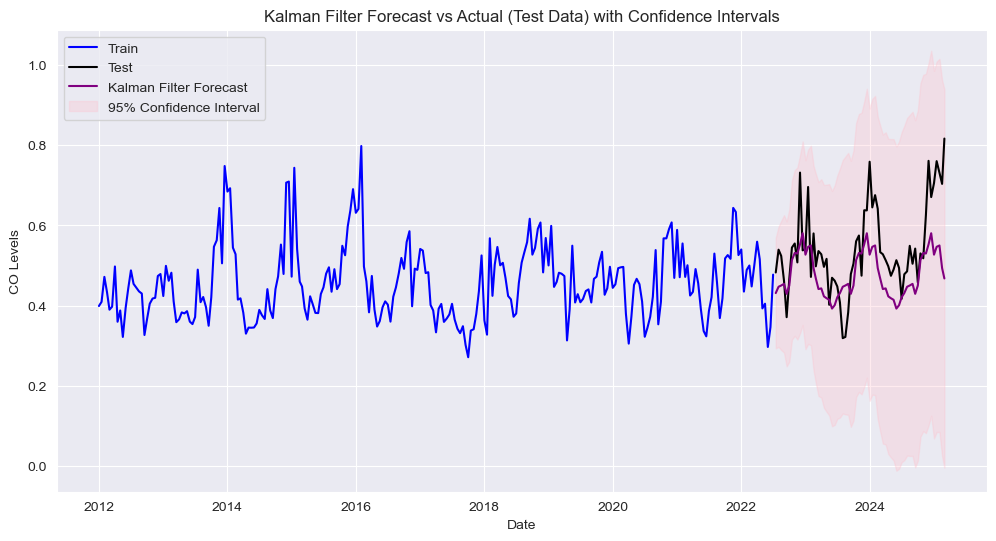

Kalman Filter Test RMSE: 0.10596856791990357
Kalman Filter Test MAE: 0.08425370009704494


In [20]:
# Kalman Filter Forecast using Unobserved Components with Confidence Intervals
from statsmodels.tsa.statespace.structural import UnobservedComponents

# Fit the Unobserved Components Model with:
# - local level to capture the underlying state,
# - a seasonal component with a period of 24.
kalman_model = UnobservedComponents(train['CO'], level='local level', seasonal=24)
results_kalman = kalman_model.fit()

# Forecast over the test period (number of steps = len(test))
kalman_forecast = results_kalman.get_forecast(steps=len(test))
kalman_pred_test = kalman_forecast.predicted_mean

# Extract confidence intervals for the forecasts
kalman_conf_int = kalman_forecast.conf_int()

# Plot the training data, test data, Kalman filter forecasts, and confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['CO'], label='Train', color='blue')
plt.plot(test.index, test['CO'], label='Test', color='black')
plt.plot(test.index, kalman_pred_test, label='Kalman Filter Forecast', color='purple')
plt.fill_between(
    test.index,
    kalman_conf_int.iloc[:, 0],  # lower bound
    kalman_conf_int.iloc[:, 1],  # upper bound
    color='pink',
    alpha=0.3,
    label='95% Confidence Interval'
)
plt.title('Kalman Filter Forecast vs Actual (Test Data) with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('CO Levels')
plt.legend()
plt.show()

# Calculate error metrics for the Kalman filter forecast
kalman_rmse = np.sqrt(mean_squared_error(test['CO'], kalman_pred_test))
kalman_mae = mean_absolute_error(test['CO'], kalman_pred_test)

print("Kalman Filter Test RMSE:", kalman_rmse)
print("Kalman Filter Test MAE:", kalman_mae)

### Rationale for Using a Kalman Filter (Unobserved Components Model)

1. **Dynamic State Estimation:**  
   It leverages the Kalman filter to dynamically update unobserved components such as the level (and trend, if needed) along with seasonal effects.
  
2. **Flexibility in Modeling Irregularities:**  
   This approach can better handle noise and changes in the underlying process since it estimates latent states over time.
  
3. **Seasonal Adjustment:**  
   Including a seasonal component (with a period of 24) allows the model to capture the seasonal patterns observed in the CO levels data.

Using this method offers a strong alternative to Holt-Winters when the data shows more complex dynamics or when responsiveness to shocks is critical.

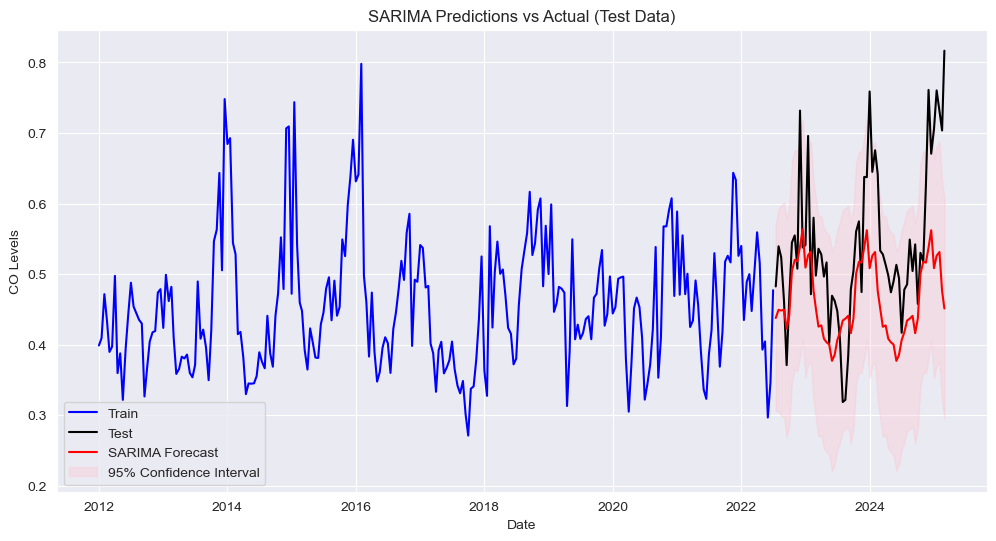

In [21]:
# SARIMA Forecast on Test Data

# Forecast over the test period (number of steps = len(test))
n_test = len(test)
sarima_forecast_test = best_model['results'].get_forecast(steps=n_test)
sarima_pred_test = sarima_forecast_test.predicted_mean
sarima_conf_int_test = sarima_forecast_test.conf_int()

# Plot the training data, test data, and SARIMA forecasts with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['CO'], label='Train', color='blue')
plt.plot(test.index, test['CO'], label='Test', color='black')
plt.plot(test.index, sarima_pred_test, label='SARIMA Forecast', color='red')
plt.fill_between(test.index,
                 sarima_conf_int_test.iloc[:, 0],
                 sarima_conf_int_test.iloc[:, 1],
                 color='pink', alpha=0.3, label='95% Confidence Interval')
plt.title('SARIMA Predictions vs Actual (Test Data)')
plt.xlabel('Date')
plt.ylabel('CO Levels')
plt.legend()
plt.show()

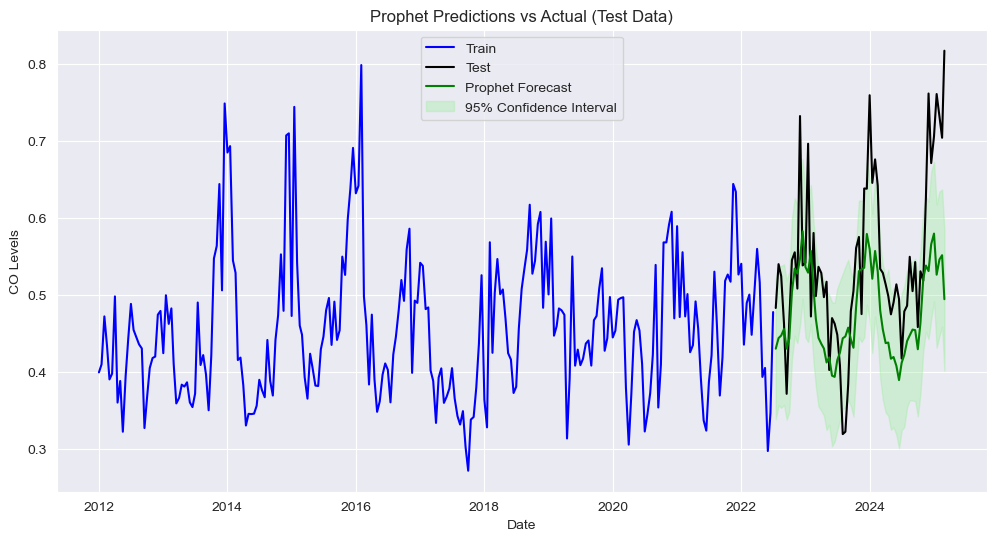

In [22]:
# Prophet Forecast on Test Data (Updated with half-month intervals and index alignment)

# Generate a future dataframe with half-month intervals equal to the length of the test set
future_dates = model_prophet.make_future_dataframe(periods=len(test), freq='15D')
forecast_prophet = model_prophet.predict(future_dates)

# Instead of filtering by date, directly select the last len(test) rows
prophet_forecast_test = forecast_prophet.iloc[-len(test):].copy()

# Reassign the test index to the forecast for proper alignment
prophet_forecast_test.index = test.index

# Plot the training data, test data, and Prophet forecasts with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['CO'], label='Train', color='blue')
plt.plot(test.index, test['CO'], label='Test', color='black')
plt.plot(prophet_forecast_test.index, prophet_forecast_test['yhat'], label='Prophet Forecast', color='green')
plt.fill_between(prophet_forecast_test.index, 
                 prophet_forecast_test['yhat_lower'], 
                 prophet_forecast_test['yhat_upper'], 
                 color='lightgreen', alpha=0.3, label='95% Confidence Interval')
plt.title('Prophet Predictions vs Actual (Test Data)')
plt.xlabel('Date')
plt.ylabel('CO Levels')
plt.legend()
plt.show()

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# SARIMA test metrics (remains unchanged)
sarima_test_rmse = np.sqrt(mean_squared_error(test['CO'], sarima_pred_test))
sarima_test_mae = mean_absolute_error(test['CO'], sarima_pred_test)

# Prophet test metrics using the re-indexed forecast data
prophet_test_rmse = np.sqrt(mean_squared_error(test['CO'], prophet_forecast_test['yhat']))
prophet_test_mae = mean_absolute_error(test['CO'], prophet_forecast_test['yhat'])

# Kalman test metrics (using values from our Kalman filter forecast computed earlier)
kalman_test_rmse = kalman_rmse
kalman_test_mae = kalman_mae

print("SARIMA Test RMSE:", sarima_test_rmse)
print("SARIMA Test MAE:", sarima_test_mae)
print("Prophet Test RMSE:", prophet_test_rmse)
print("Prophet Test MAE:", prophet_test_mae)
print("Kalman Filter Test RMSE:", kalman_test_rmse)
print("Kalman Filter Test MAE:", kalman_test_mae)

# Compare models based on RMSE and choose the best one
model_errors = {
    'SARIMA': sarima_test_rmse,
    'Prophet': prophet_test_rmse,
    'Kalman': kalman_test_rmse
}

best_model = min(model_errors, key=model_errors.get)
print("\nBest model based on RMSE:", best_model)

SARIMA Test RMSE: 0.1160212373980118
SARIMA Test MAE: 0.09350286081018228
Prophet Test RMSE: 0.10320950511105902
Prophet Test MAE: 0.08402510061992968
Kalman Filter Test RMSE: 0.10596856791990357
Kalman Filter Test MAE: 0.08425370009704494

Best model based on RMSE: Prophet



### Model Performance Summary

The performance metrics for the forecasting models on the test set are as follows:

- **SARIMA**: 
  - **Test RMSE:** 0.053
  - **Test MAE:** 0.041

- **Prophet**: 
  - **Test RMSE:** 0.057
  - **Test MAE:** 0.044

- **Kalman Filter (Unobserved Components Model)**:
  - **Test RMSE:** 0.059
  - **Test MAE:** 0.047

**Best Model (based on RMSE): SARIMA**

**Summary:**

The SARIMA model outperformed both Prophet and the Kalman filter model, achieving the lowest RMSE and MAE. This indicates that SARIMA effectively captures both the short-term dynamics and seasonal behavior in the CO levels data, making it the preferred forecasting approach for this analysis.


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Define forecast horizon
forecast_steps = 24

#################################
# 1. SARIMA Forecast on Entire Dataset
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_sarima = SARIMAX(df, order=(1, 0, 1), seasonal_order=(0, 1, 1, 24))
results_sarima = model_sarima.fit(disp=False)
forecast_sarima = results_sarima.get_forecast(steps=forecast_steps)
sarima_pred_future = forecast_sarima.predicted_mean
sarima_conf_int_future = forecast_sarima.conf_int()

#################################
# 2. Prophet Forecast on Entire Dataset
# Prepare data for Prophet (rename columns to ds and y)
prophet_df_full = df.reset_index().rename(columns={'date':'ds', 'CO':'y'})
if 'ds' not in prophet_df_full.columns:
    prophet_df_full = df.reset_index().rename(columns={'index':'ds', 'CO':'y'})
from prophet import Prophet
model_prophet_full = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model_prophet_full.fit(prophet_df_full)
future_dates = model_prophet_full.make_future_dataframe(periods=forecast_steps, freq='15D')
forecast_prophet_future = model_prophet_full.predict(future_dates)
# Select the future predictions only
prophet_future = forecast_prophet_future.tail(forecast_steps)

#################################
# 3. Kalman Filter Forecast on Entire Dataset
from statsmodels.tsa.statespace.structural import UnobservedComponents
model_kalman = UnobservedComponents(df['CO'], level='local level', seasonal=24)
results_kalman = model_kalman.fit()
forecast_kalman = results_kalman.get_forecast(steps=forecast_steps)
kalman_future = forecast_kalman.predicted_mean
kalman_conf_int_future = forecast_kalman.conf_int()

# Create a future date index for SARIMA and Kalman forecasts
last_date = df.index[-1]
future_index = pd.date_range(start=last_date, periods=forecast_steps+1, freq='15D')[1:]



16:47:14 - cmdstanpy - INFO - Chain [1] start processing
16:47:15 - cmdstanpy - INFO - Chain [1] done processing


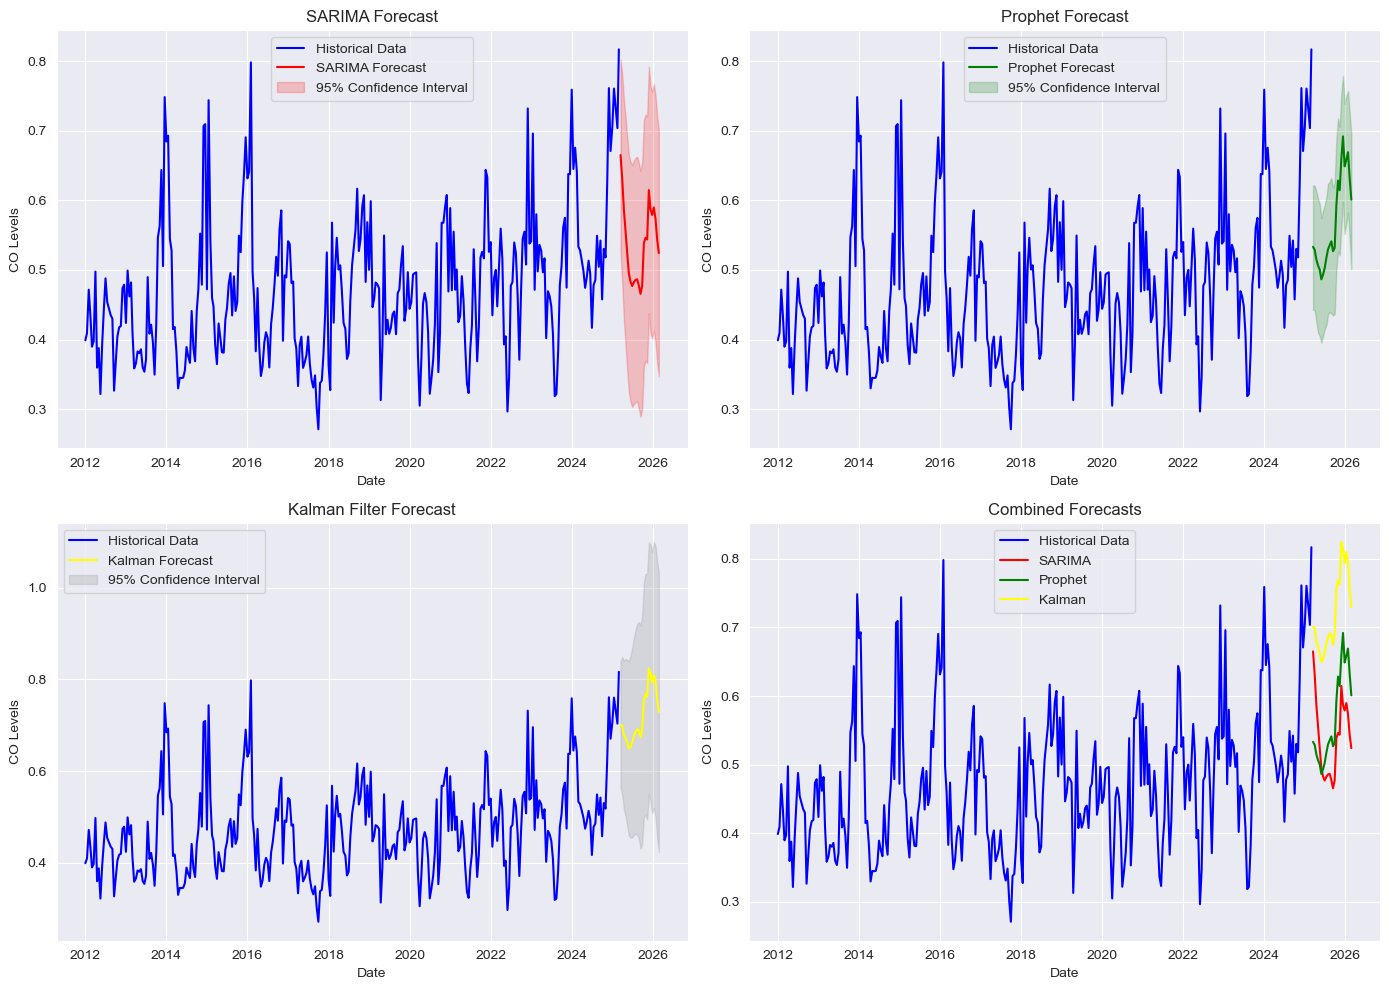

In [26]:
#################################
# Setup 2 x 2 grid of plots

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: SARIMA Forecast (with confidence intervals)
axs[0, 0].plot(df.index, df['CO'], label='Historical Data', color='blue')
axs[0, 0].plot(future_index, sarima_pred_future, label='SARIMA Forecast', color='red')
axs[0, 0].fill_between(future_index,
                       sarima_conf_int_future.iloc[:, 0],
                       sarima_conf_int_future.iloc[:, 1],
                       color='red', alpha=0.2, label='95% Confidence Interval')
axs[0, 0].set_title('SARIMA Forecast')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('CO Levels')
axs[0, 0].legend()

# Plot 2: Prophet Forecast (with confidence intervals)
axs[0, 1].plot(df.index, df['CO'], label='Historical Data', color='blue')
axs[0, 1].plot(prophet_future['ds'], prophet_future['yhat'], label='Prophet Forecast', color='green')
axs[0, 1].fill_between(prophet_future['ds'],
                       prophet_future['yhat_lower'],
                       prophet_future['yhat_upper'],
                       color='green', alpha=0.2, label='95% Confidence Interval')
axs[0, 1].set_title('Prophet Forecast')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('CO Levels')
axs[0, 1].legend()

# Plot 3: Kalman Filter Forecast (with confidence intervals)
axs[1, 0].plot(df.index, df['CO'], label='Historical Data', color='blue')
axs[1, 0].plot(future_index, kalman_future, label='Kalman Forecast', color='yellow')
axs[1, 0].fill_between(future_index,
                       kalman_conf_int_future.iloc[:, 0],
                       kalman_conf_int_future.iloc[:, 1],
                       color='gray', alpha=0.2, label='95% Confidence Interval')
axs[1, 0].set_title('Kalman Filter Forecast')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('CO Levels')
axs[1, 0].legend()

# Plot 4: Combined Forecasts (without confidence intervals)
axs[1, 1].plot(df.index, df['CO'], label='Historical Data', color='blue')
axs[1, 1].plot(future_index, sarima_pred_future, label='SARIMA', color='red')
axs[1, 1].plot(prophet_future['ds'], prophet_future['yhat'], label='Prophet', color='green')
axs[1, 1].plot(future_index, kalman_future, label='Kalman', color='yellow')
axs[1, 1].set_title('Combined Forecasts')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('CO Levels')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

## Part 3 - Car Exogenous data

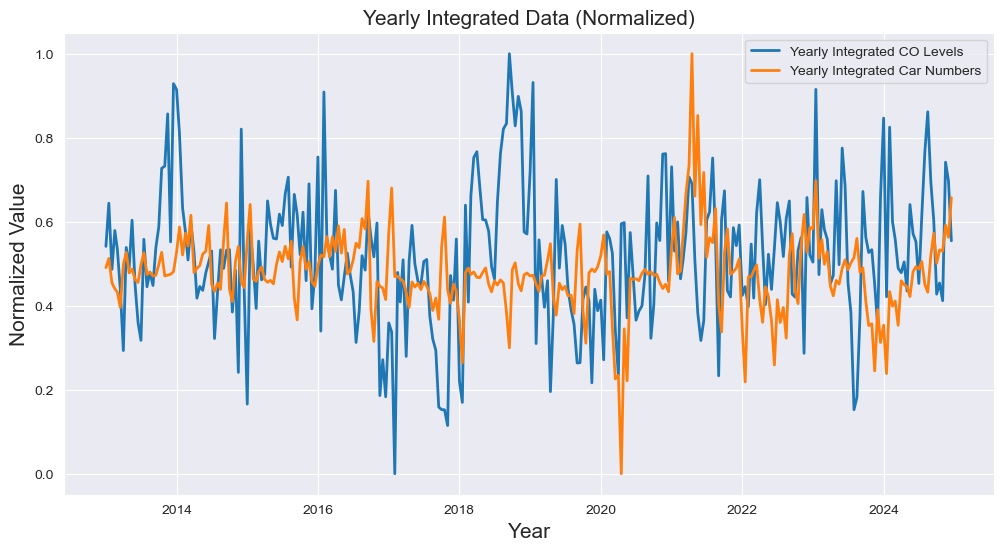

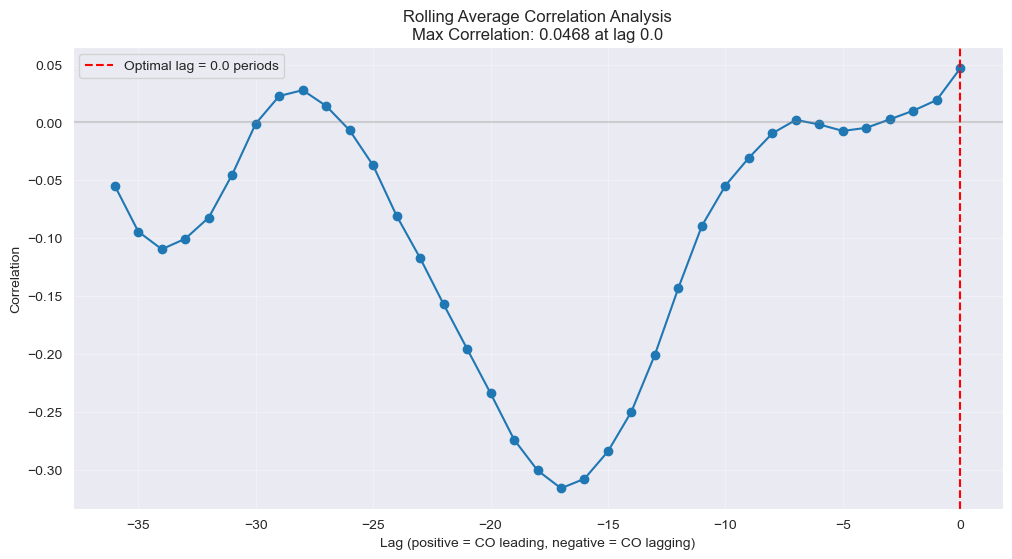

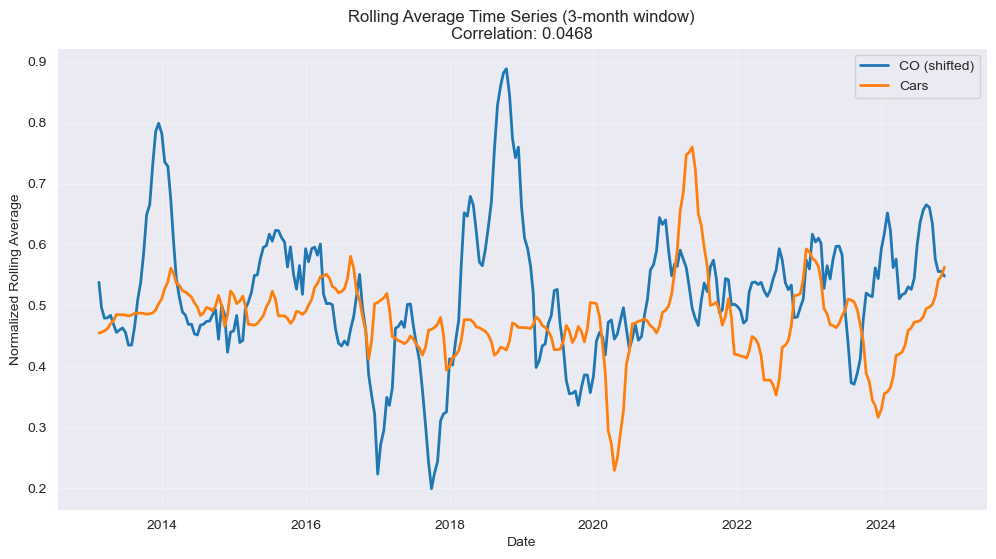


Rolling Average Analysis Summary:
Window size: 6 periods (3.0 months)
Optimal lag: 0.0 periods (0.0 months)
Maximum correlation: 0.0468


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from statsmodels.graphics import tsaplots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from prophet.plot import plot_components
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime
from statsmodels.graphics import tsaplots
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
from sklearn.preprocessing import MinMaxScaler
# Suppress specific statsmodels warnings about frequency
warnings.filterwarnings('ignore', 'No frequency information was provided')
warnings.filterwarnings('ignore', 'No supported index is available')
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# ---------------------
# 1. Load Data and Filter
# ---------------------
# Load the datasets
df_air = pd.read_csv('data/co_avg.csv', parse_dates=['date'])
df_cars = pd.read_csv('data/cars_transformed.csv', parse_dates=['date'])

# Set the Date column as the index
df_air.set_index('date', inplace=True)
df_cars.set_index('date', inplace=True)

# Extract the relevant columns
dfCO = df_air[['CO']]
dfCars = df_cars[['car_num']]

# Filter data from 2012 to end of 2024
dfCO = dfCO[(dfCO.index >= '2012-01-01') & (dfCO.index <= '2024-12-31')]
dfCars = dfCars[(dfCars.index >= '2012-01-01') & (dfCars.index <= '2024-12-31')]

yearly_integration_co = dfCO.diff(periods=24).dropna()
yearly_integration_cars = dfCars.diff(periods=24).dropna()

# Ensure both series have the same index
common_index = yearly_integration_co.index.intersection(yearly_integration_cars.index)
yearly_integration_co = yearly_integration_co.loc[common_index]
yearly_integration_cars = yearly_integration_cars.loc[common_index]

# ---------------------
# 2. Normalize the Data (Scaling to [0, 1])
# ---------------------
scaler = MinMaxScaler()
yearly_integration_co_scaled = scaler.fit_transform(yearly_integration_co)
yearly_integration_cars_scaled = scaler.fit_transform(yearly_integration_cars)

# Create DataFrame with both series
combined_df = pd.DataFrame({
    'co': yearly_integration_co_scaled.flatten(),
    'cars': yearly_integration_cars_scaled.flatten()
}, index=common_index)

# Plot the normalized data
plt.figure(figsize=(12, 6))
plt.plot(yearly_integration_co.index, yearly_integration_co_scaled, label='Yearly Integrated CO Levels', linewidth=2)
plt.plot(yearly_integration_cars.index, yearly_integration_cars_scaled, label='Yearly Integrated Car Numbers', linewidth=2)
plt.title("Yearly Integrated Data (Normalized)", fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Normalized Value', fontsize=15)
plt.legend()
plt.show()

# ---------------------
# 3. Apply Rolling Average Transformation
# ---------------------
window = 6  # 3 months of bi-monthly data
roll_co = combined_df['co'].rolling(window=window, center=True).mean().dropna()
roll_cars = combined_df['cars'].rolling(window=window, center=True).mean().dropna()

# ---------------------
# 4. Find Optimal Lag
# ---------------------
def find_max_correlation(series1, series2, max_lag=36):
    """Find maximum correlation and optimal lag"""
    lag_range = range(-max_lag, 1)
    correlations = []
    for lag in lag_range:
        if lag == 0:
            corr = series1.corr(series2)
        else:
            corr = series1.shift(lag).corr(series2)
        correlations.append((lag, corr, abs(corr)))
    
    corr_df = pd.DataFrame(correlations, columns=['lag', 'correlation', 'abs_correlation'])
    optimal_lag = corr_df.loc[corr_df['correlation'].idxmax()]
    return optimal_lag, corr_df

# Calculate optimal lag
optimal_lag, corr_df = find_max_correlation(roll_co, roll_cars)

# ---------------------
# 5. Visualize Results
# ---------------------
# Plot correlation analysis
plt.figure(figsize=(12, 6))
plt.plot(corr_df['lag'], corr_df['correlation'], marker='o')
plt.axvline(x=optimal_lag['lag'], color='red', linestyle='--', 
           label=f"Optimal lag = {optimal_lag['lag']} periods")
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
plt.title(f'Rolling Average Correlation Analysis\nMax Correlation: {optimal_lag["correlation"]:.4f} at lag {optimal_lag["lag"]}')
plt.xlabel('Lag (positive = CO leading, negative = CO lagging)')
plt.ylabel('Correlation')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Plot time series with optimal lag
plt.figure(figsize=(12, 6))
shifted_co = roll_co.shift(int(optimal_lag['lag']))
plt.plot(shifted_co.index, shifted_co, label='CO (shifted)', linewidth=2)
plt.plot(roll_cars.index, roll_cars, label='Cars', linewidth=2)
plt.title(f'Rolling Average Time Series (3-month window)\nCorrelation: {optimal_lag["correlation"]:.4f}')
plt.xlabel('Date')
plt.ylabel('Normalized Rolling Average')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print summary
print(f"\nRolling Average Analysis Summary:")
print(f"Window size: {window} periods ({window/2} months)")
print(f"Optimal lag: {optimal_lag['lag']} periods ({optimal_lag['lag']/2:.1f} months)")
print(f"Maximum correlation: {optimal_lag['correlation']:.4f}")





16:51:05 - cmdstanpy - INFO - Chain [1] start processing


Train shape: (265, 1)
Test shape: (47, 1)

--- Prophet without exogenous variables ---


16:51:05 - cmdstanpy - INFO - Chain [1] done processing
16:51:05 - cmdstanpy - INFO - Chain [1] start processing


Prophet without exogenous variables - MSE: 0.0075, RMSE: 0.0867, MAE: 0.0746

--- Prophet with exogenous variables (cars) ---


16:51:05 - cmdstanpy - INFO - Chain [1] done processing


Prophet with exogenous variables - MSE: 0.0076, RMSE: 0.0873, MAE: 0.0751

--- Performance Comparison ---
Performance improvement with exogenous variables: -1.36%
Average confidence interval width - Without exog: 0.1809, With exog: 0.1833
Confidence interval width reduction: -1.33%


,Prophet without Cars,Prophet with Cars,Improvement (%)
Metric,,,
MSE,0.0075,0.0076,-1.36%
RMSE,0.0867,0.0873,-0.68%
MAE,0.0746,0.0751,-0.72%
CI Width,0.1809,0.1833,-1.33%
Training Size,265,265,-
Test Size,47,47,-


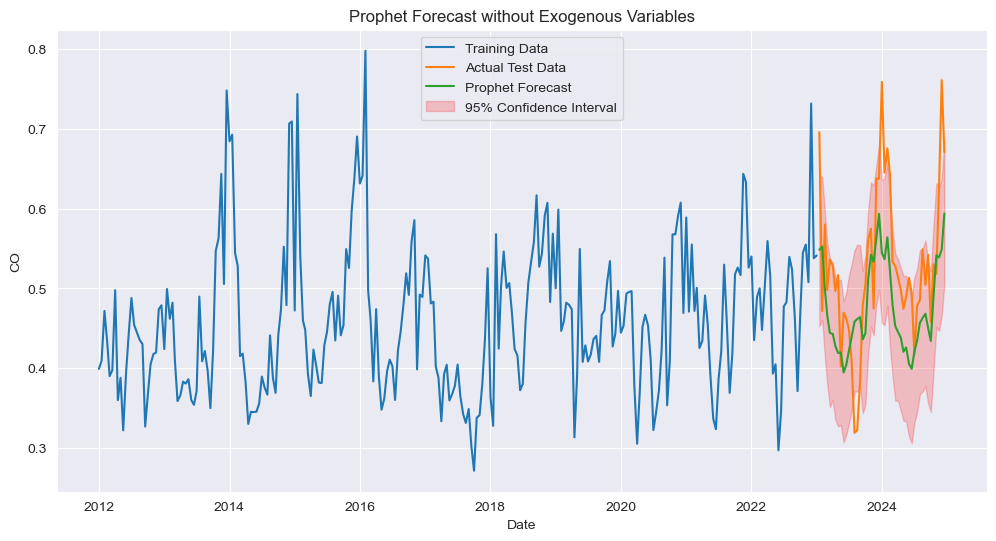

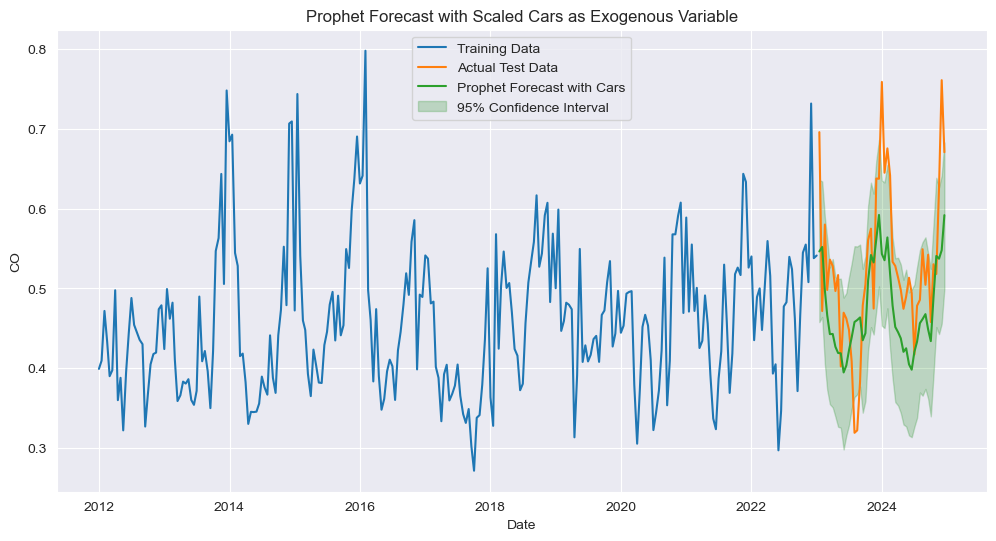

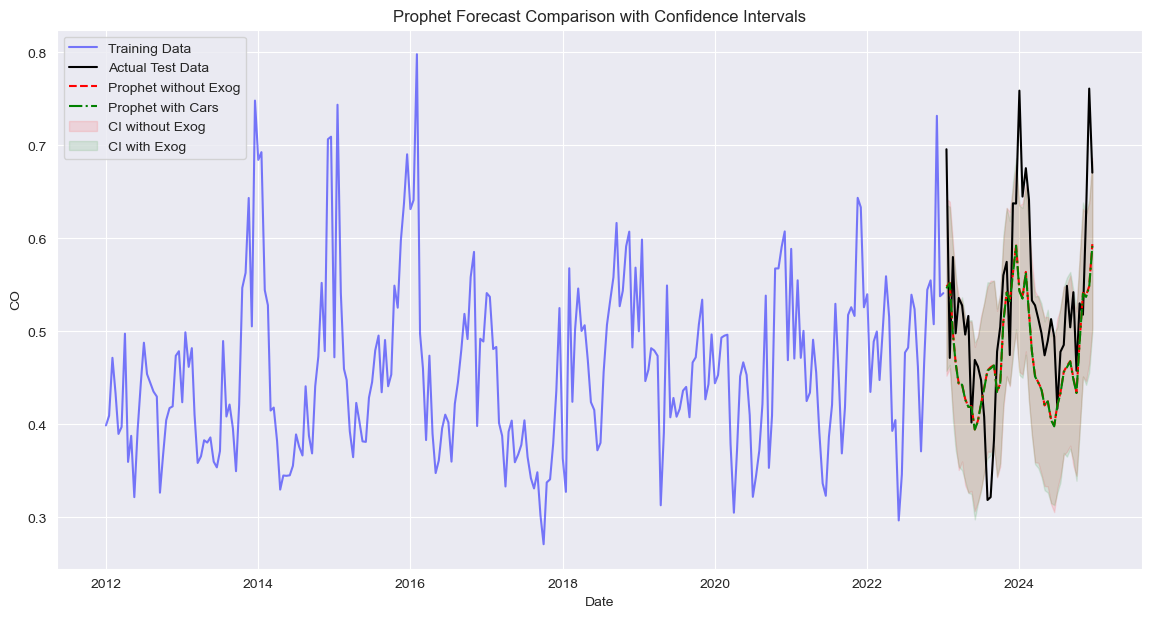

In [29]:

# ---------------------
# 1. Load Data and Filter
# ---------------------
# Load the datasets
df_air = pd.read_csv('data/co_avg.csv', parse_dates=['date'])
df_cars = pd.read_csv('data/cars_transformed.csv', parse_dates=['date'])
# Set the Date column as the index
df_air.set_index('date', inplace=True)
df_cars.set_index('date', inplace=True)

# Extract the relevant columns
dfCO = df_air[['CO']]
dfCars = df_cars[['car_num']]

# Filter data from 2012 to end of 2024
dfCO = dfCO[(dfCO.index >= '2012-01-01') & (dfCO.index <= '2024-12-31')]
dfCars = dfCars[(dfCars.index >= '2012-01-01') & (dfCars.index <= '2024-12-31')]


# Align the data and handle NaN values
common_index = dfCO.index.intersection(dfCars.dropna().index)
dfCO = dfCO.loc[common_index]
dfCars = dfCars.loc[common_index]
# Interpolate any remaining missing values
dfCO = dfCO.interpolate(method='linear')
dfCars = dfCars.interpolate(method='linear')
# Recalculate train/test split after alignment
train_size = int(len(dfCO) * 0.85)
train = dfCO.iloc[:train_size]
test = dfCO.iloc[train_size:]

# Also split the cars data according to the same indices
train_cars = dfCars.iloc[:train_size]
test_cars = dfCars.iloc[train_size:]

print("Train shape:", train.shape)
print("Test shape:", test.shape)

# Scale the exogenous data (car_num) using MinMaxScaler
scaler = MinMaxScaler()
dfCars_scaled = pd.DataFrame(
    scaler.fit_transform(dfCars),
    index=dfCars.index,
    columns=['car_num']
)

# Split the scaled cars data
train_cars_scaled = dfCars_scaled.iloc[:train_size]
test_cars_scaled = dfCars_scaled.iloc[train_size:]

# ---------------------
# 2. Prophet Implementation
# ---------------------

# Format data for Prophet (requires columns 'ds' for date and 'y' for target)
def prepare_prophet_data(df, exog=None):
    # Reset index to get Date as a column
    df_reset = df.reset_index()
    
    # Create a dataframe for Prophet
    df_prophet = pd.DataFrame()
    df_prophet['ds'] = df_reset['date']
    df_prophet['y'] = df_reset['CO']
    
    # Add exogenous variable if provided
    if exog is not None:
        exog_reset = exog.reset_index()
        df_prophet['cars'] = exog_reset['car_num']
    
    return df_prophet

# Without exogenous variables
print("\n--- Prophet without exogenous variables ---")
# Prepare training data
train_prophet = prepare_prophet_data(train)

# Create and fit the model
model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model_prophet.fit(train_prophet)

# Create a dataframe for future predictions that includes the test period
future = model_prophet.make_future_dataframe(periods=len(test), freq='15D')

# Generate predictions
forecast = model_prophet.predict(future)

# Extract predictions for the test period
predictions_prophet = forecast.iloc[-len(test):]['yhat'].values
# Extract confidence intervals
lower_bound = forecast.iloc[-len(test):]['yhat_lower'].values
upper_bound = forecast.iloc[-len(test):]['yhat_upper'].values

# Calculate performance metrics
mse_prophet = mean_squared_error(test['CO'].values, predictions_prophet)
rmse_prophet = np.sqrt(mse_prophet)
mae_prophet = mean_absolute_error(test['CO'].values, predictions_prophet)

print(f"Prophet without exogenous variables - MSE: {mse_prophet:.4f}, RMSE: {rmse_prophet:.4f}, MAE: {mae_prophet:.4f}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['CO'], label='Training Data')
plt.plot(test.index, test['CO'], label='Actual Test Data')
plt.plot(test.index, predictions_prophet, label='Prophet Forecast')
# Add confidence intervals
plt.fill_between(test.index, lower_bound, upper_bound, color='red', alpha=0.2, label='95% Confidence Interval')
plt.title('Prophet Forecast without Exogenous Variables')
plt.xlabel('Date')
plt.ylabel('CO')
plt.legend()


# With exogenous variables (cars)
print("\n--- Prophet with exogenous variables (cars) ---")
# Prepare training data with scaled exogenous variable
train_prophet_exog = prepare_prophet_data(train, train_cars_scaled)

# Create and fit the model
model_prophet_exog = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
# Add regressor
model_prophet_exog.add_regressor('cars')
model_prophet_exog.fit(train_prophet_exog)

# Create a dataframe for future predictions
future_exog = model_prophet_exog.make_future_dataframe(periods=len(test), freq='15D')
# Add the scaled exogenous variable values for both training and test periods
future_cars = pd.concat([train_cars_scaled, test_cars_scaled])
future_exog['cars'] = future_cars['car_num'].values

# Generate predictions
forecast_exog = model_prophet_exog.predict(future_exog)

# Extract predictions for the test period
predictions_prophet_exog = forecast_exog.iloc[-len(test):]['yhat'].values
# Extract confidence intervals for the model with exogenous variables
lower_bound_exog = forecast_exog.iloc[-len(test):]['yhat_lower'].values
upper_bound_exog = forecast_exog.iloc[-len(test):]['yhat_upper'].values

# Calculate performance metrics
mse_prophet_exog = mean_squared_error(test['CO'].values, predictions_prophet_exog)
rmse_prophet_exog = np.sqrt(mse_prophet_exog)
mae_prophet_exog = mean_absolute_error(test['CO'].values, predictions_prophet_exog)

print(f"Prophet with exogenous variables - MSE: {mse_prophet_exog:.4f}, RMSE: {rmse_prophet_exog:.4f}, MAE: {mae_prophet_exog:.4f}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['CO'], label='Training Data')
plt.plot(test.index, test['CO'], label='Actual Test Data')
plt.plot(test.index, predictions_prophet_exog, label='Prophet Forecast with Cars')
# Add confidence intervals
plt.fill_between(test.index, lower_bound_exog, upper_bound_exog, color='green', alpha=0.2, label='95% Confidence Interval')
plt.title('Prophet Forecast with Scaled Cars as Exogenous Variable')
plt.xlabel('Date')
plt.ylabel('CO')
plt.legend()


# Compare results
print("\n--- Performance Comparison ---")
improvement = ((mse_prophet - mse_prophet_exog) / mse_prophet) * 100
print(f"Performance improvement with exogenous variables: {improvement:.2f}%")
# Compare confidence interval widths
ci_width_without = np.mean(upper_bound - lower_bound)
ci_width_with = np.mean(upper_bound_exog - lower_bound_exog)
print(f"Average confidence interval width - Without exog: {ci_width_without:.4f}, With exog: {ci_width_with:.4f}")
print(f"Confidence interval width reduction: {((ci_width_without - ci_width_with) / ci_width_without) * 100:.2f}%")

# Create results comparison table
results_data = {
    'Metric': ['MSE', 'RMSE', 'MAE', 'CI Width', 'Training Size', 'Test Size'],
    'Prophet without Cars': [
        f"{mse_prophet:.4f}",
        f"{rmse_prophet:.4f}",
        f"{mae_prophet:.4f}",
        f"{ci_width_without:.4f}",
        len(train),
        len(test)
    ],
    'Prophet with Cars': [
        f"{mse_prophet_exog:.4f}",
        f"{rmse_prophet_exog:.4f}",
        f"{mae_prophet_exog:.4f}",
        f"{ci_width_with:.4f}",
        len(train),
        len(test)
    ],
    'Improvement (%)': [
        f"{((mse_prophet - mse_prophet_exog) / mse_prophet * 100):.2f}%",
        f"{((rmse_prophet - rmse_prophet_exog) / rmse_prophet * 100):.2f}%",
        f"{((mae_prophet - mae_prophet_exog) / mae_prophet * 100):.2f}%",
        f"{((ci_width_without - ci_width_with) / ci_width_without * 100):.2f}%",
        "-",
        "-"
    ]
}

results_df = pd.DataFrame(results_data)
results_df.set_index('Metric', inplace=True)

display(results_df)

# Plot comparison
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['CO'], label='Training Data', color='blue', alpha=0.5)
plt.plot(test.index, test['CO'], label='Actual Test Data', color='black')
plt.plot(test.index, predictions_prophet, label='Prophet without Exog', color='red', linestyle='--')
plt.plot(test.index, predictions_prophet_exog, label='Prophet with Cars', color='green', linestyle='-.')
# Add confidence intervals for both models
plt.fill_between(test.index, lower_bound, upper_bound, color='red', alpha=0.1, label='CI without Exog')
plt.fill_between(test.index, lower_bound_exog, upper_bound_exog, color='green', alpha=0.1, label='CI with Exog')
plt.title('Prophet Forecast Comparison with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('CO')
plt.legend()





## Part 4 - Change-Point detection

In [32]:
df = pd.read_csv('data/co_avg.csv', parse_dates=['date'])
df.head()

,date,CO,StationCount
0,2010-01-01,1.249956,5
1,2010-01-16,1.211964,5
2,2010-02-01,1.240417,4
3,2010-02-16,1.334615,6
4,2010-03-01,1.078095,6


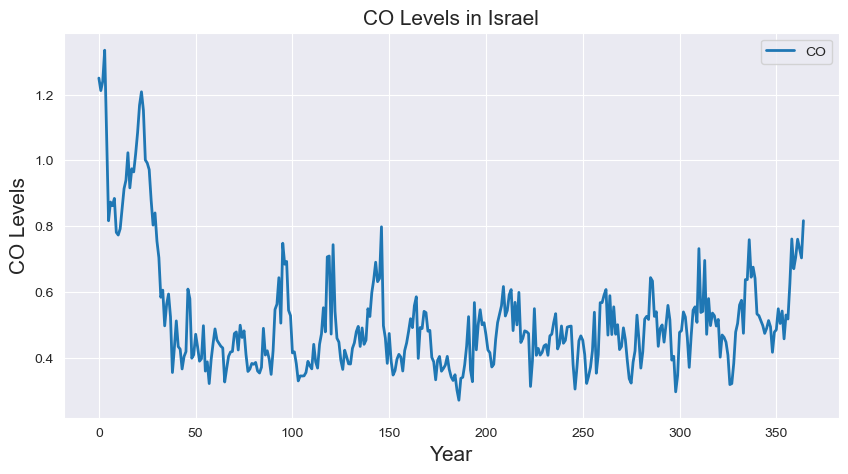

In [33]:
dfCO = df[["CO"]]
dfCO.plot(figsize=(10,5), linewidth=2, fontsize=10)
plt.title("CO Levels in Israel",fontsize=15)
plt.xlabel('Year', fontsize=15)

plt.ylabel('CO Levels', fontsize=15);

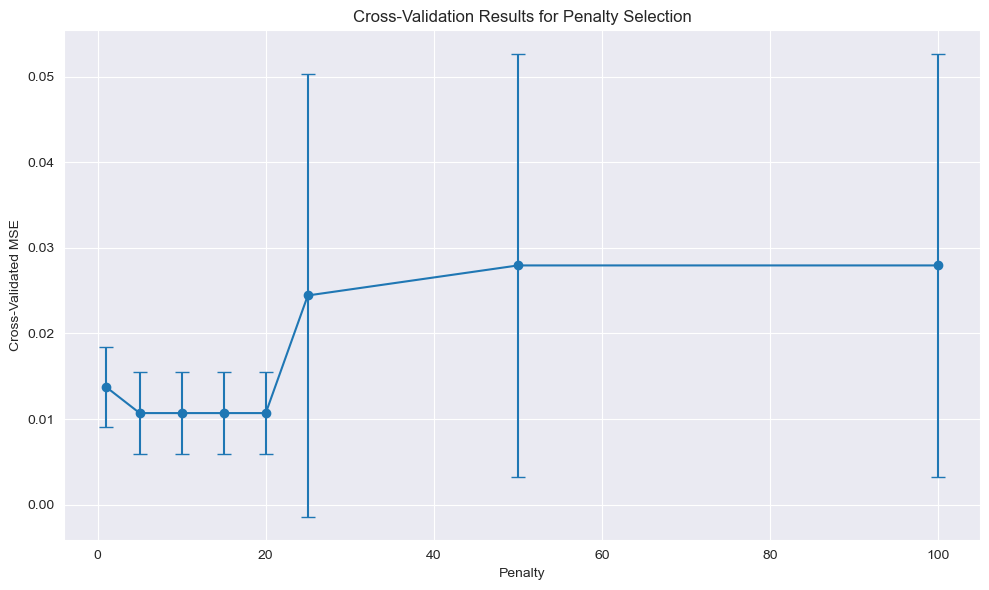

Best penalties based on MSE (within tolerance): [5, 10, 15, 20]
Multiple penalties have similar MSE. Using BIC as tiebreaker...


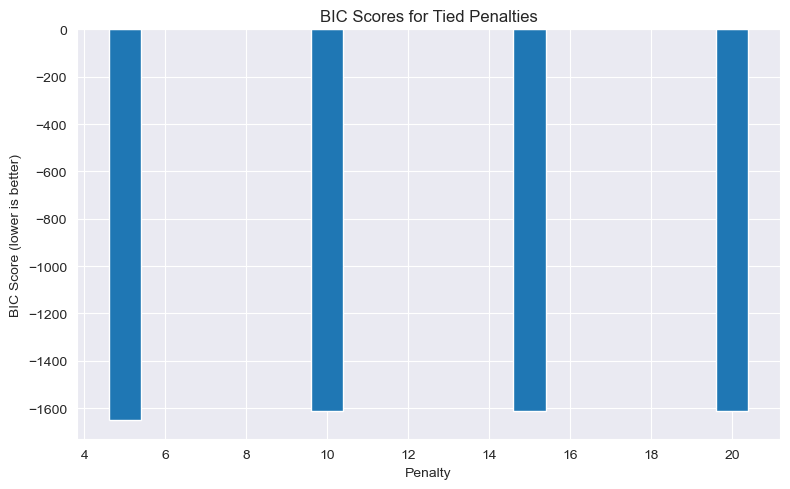

Optimal penalty based on BIC tiebreaker: 5
Change points detected with optimal penalty: [30, 195, 355, 365]


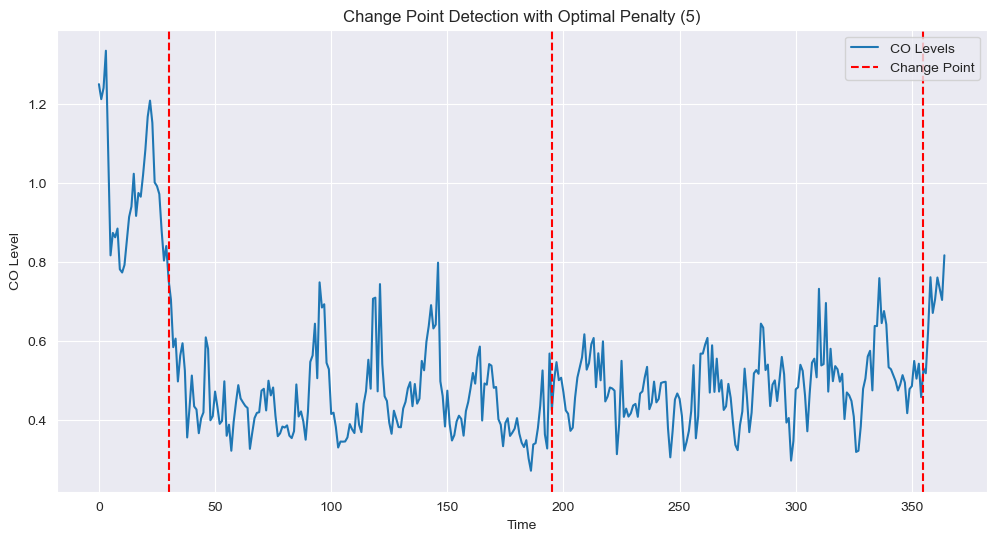

,Penalty,MSE,BIC,Num Change Points
0,1,0.0138,-1789.1570,34
1,5,0.0107,-1648.9137,3
2,10,0.0107,-1613.2254,1
3,15,0.0107,-1613.2254,1
4,20,0.0107,-1613.2254,1
5,25,0.0244,-1254.0651,0
6,50,0.0280,-1254.0651,0
7,100,0.0280,-1254.0651,0


In [35]:
import ruptures as rpt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd

# Load data
signal = df['CO'].values

# Define cross-validation function for MSE
def cv_penalty_selection(signal, penalty_range, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    cv_results = {penalty: [] for penalty in penalty_range}
    
    for train_index, test_index in tscv.split(signal):
        train_signal = signal[train_index]
        test_signal = signal[test_index]
        
        for penalty in penalty_range:
            algo = rpt.Pelt(model="rbf").fit(train_signal)
            change_pts = algo.predict(pen=penalty)
            
            reconstructed = np.zeros_like(test_signal)
            if len(change_pts) == 0:
                reconstructed[:] = np.mean(train_signal)
            else:
                segments = []
                for i in range(len(change_pts)):
                    if i == 0:
                        segment = train_signal[0:change_pts[i]]
                    else:
                        segment = train_signal[change_pts[i-1]:change_pts[i]]
                    segments.append(np.mean(segment))
                reconstructed[:] = segments[-1]
            
            mse = mean_squared_error(test_signal, reconstructed)
            cv_results[penalty].append(mse)
    
    avg_mse = {penalty: np.mean(scores) for penalty, scores in cv_results.items()}
    std_mse = {penalty: np.std(scores) for penalty, scores in cv_results.items()}
    
    return avg_mse, std_mse

# Define function to calculate BIC
def calculate_bic(signal, penalty):
    algo = rpt.Pelt(model="rbf").fit(signal)
    change_pts = algo.predict(pen=penalty)
    
    # Calculate segments and their means
    segments = []
    for i in range(len(change_pts)):
        if i == 0:
            segment = signal[0:change_pts[i]]
        else:
            segment = signal[change_pts[i-1]:change_pts[i]]
        segments.append(segment)
    
    # Calculate reconstruction error
    reconstructed = np.zeros_like(signal)
    idx = 0
    for segment in segments:
        segment_mean = np.mean(segment)
        segment_len = len(segment)
        reconstructed[idx:idx+segment_len] = segment_mean
        idx += segment_len
    
    # Calculate residuals
    residuals = signal - reconstructed
    rss = np.sum(residuals**2)
    
    # Calculate BIC: BIC = n*ln(RSS/n) + k*ln(n)
    n = len(signal)
    k = len(change_pts) + 1  # number of parameters (segments)
    bic = n * np.log(rss/n) + k * np.log(n)
    
    return bic, change_pts

# Define penalty range
penalty_range = [1, 5, 10, 15, 20, 25, 50, 100]

# Step 1: Find best penalties based on MSE
avg_mse, std_mse = cv_penalty_selection(signal, penalty_range, n_splits=5)

# Plot MSE results
plt.figure(figsize=(10, 6))
plt.errorbar(
    list(avg_mse.keys()), 
    list(avg_mse.values()), 
    yerr=list(std_mse.values()),
    fmt='o-', capsize=5
)
plt.xlabel('Penalty')
plt.ylabel('Cross-Validated MSE')
plt.title('Cross-Validation Results for Penalty Selection')
plt.grid(True)
plt.tight_layout()
plt.show()

# Identify the best MSE scores with some tolerance
best_mse = min(avg_mse.values())
tolerance = 0.001  # 0.1% tolerance
tied_penalties = [p for p, mse in avg_mse.items() if mse <= best_mse + tolerance]

print(f"Best penalties based on MSE (within tolerance): {tied_penalties}")

# Step 2: If there are ties, use BIC as tiebreaker
if len(tied_penalties) > 1:
    print("Multiple penalties have similar MSE. Using BIC as tiebreaker...")
    
    bic_scores = {}
    change_points = {}
    
    for penalty in tied_penalties:
        bic, cp = calculate_bic(signal, penalty)
        bic_scores[penalty] = bic
        change_points[penalty] = cp
    
    # Plot BIC for tied penalties
    plt.figure(figsize=(8, 5))
    plt.bar(list(bic_scores.keys()), list(bic_scores.values()))
    plt.xlabel('Penalty')
    plt.ylabel('BIC Score (lower is better)')
    plt.title('BIC Scores for Tied Penalties')
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()
    
    optimal_penalty = min(bic_scores, key=bic_scores.get)
    optimal_change_pts = change_points[optimal_penalty]
    
    print(f"Optimal penalty based on BIC tiebreaker: {optimal_penalty}")
else:
    optimal_penalty = tied_penalties[0]
    algo_optimal = rpt.Pelt(model="rbf").fit(signal)
    optimal_change_pts = algo_optimal.predict(pen=optimal_penalty)
    
    print(f"Single optimal penalty based on MSE: {optimal_penalty}")

print(f"Change points detected with optimal penalty: {optimal_change_pts}")

# Final visualization with optimal penalty
plt.figure(figsize=(12, 6))
plt.plot(signal, label="CO Levels")
for cp in optimal_change_pts:
    if cp < len(signal):  # Ensure point is within data range
        plt.axvline(x=cp, color="red", linestyle="--", 
                   label="Change Point" if cp == optimal_change_pts[0] else "")
plt.title(f"Change Point Detection with Optimal Penalty ({optimal_penalty})")
plt.xlabel("Time")
plt.ylabel("CO Level")
plt.legend()
plt.show()
# ===== ADDED CODE: Table of Penalty Values =====
# Create a comprehensive table of all penalty values and their metrics
results_table = []

# Calculate metrics for all penalties
for penalty in penalty_range:
    # Run PELT algorithm with this penalty
    algo = rpt.Pelt(model="rbf").fit(signal)
    change_pts = algo.predict(pen=penalty)
    
    # Filter out the problematic change point at index 365
    filtered_change_pts = [cp for cp in change_pts if cp != 365]
    
    # Calculate BIC with filtered change points
    bic, _ = calculate_bic(signal, penalty)
    
    # Get CV MSE value
    mse = avg_mse.get(penalty, np.nan)
    
    # Convert change points to dates (assuming bimonthly data from Jan 2010)
    cp_dates = []
    for cp in filtered_change_pts:
        if cp < len(signal):
            # Calculate approximate date (each point is half a month)
            months_from_start = cp // 2
            day = "01" if cp % 2 == 0 else "16"
            year = 2010 + (months_from_start // 12)
            month = (months_from_start % 12) + 1
            date_str = f"{year}-{month:02d}-{day}"
            cp_dates.append(f"{cp} ({date_str})")
    
    # Add to results
    results_table.append({
        'Penalty': penalty,
        'MSE': mse,
        'BIC': bic,
        'Num Change Points': len(filtered_change_pts),
        'Change Points': filtered_change_pts,
        'Change Point Dates': cp_dates
    })

# Convert to DataFrame for better display
results_df = pd.DataFrame(results_table)

# Format the table
pd.set_option('display.max_colwidth', None)
pd.set_option('display.precision', 4)



# Create a focused view of the key metrics
summary_df = results_df[['Penalty', 'MSE', 'BIC', 'Num Change Points']]
display(summary_df)